# **ALPIDE**: analysis of beam opening

## Preliminary operations

### Load packages

In [1]:
import os
import sys
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
import multiprocessing

Welcome to JupyROOT 6.22/06


In [2]:
from pathlib import Path
from scipy.optimize import curve_fit

### Flags

In [3]:
ROOT.disableJSVis()

### Settings

In [4]:
N_cpu     = multiprocessing.cpu_count()
N_Threads = "%d" % (N_cpu-2)

In [5]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

### Functions

In [6]:
def make_histo(Data_array,Title,nbins,xmin,xmax,save=False):
    Histo = ROOT.TH1F(Title, Title, nbins, xmin, xmax)
    for value in Data_array:
        Histo.Fill(value)

    Canv = ROOT.TCanvas()
    Histo.Draw()
    
    if save:
        Image_name = Title + '_Histo.pdf'
        Canv.Print(Image_name)
    
    return Histo, Canv

In [7]:
def parabola(x, a, b, c):
    return a*x**2 + b*x + c

## Analysis of beam opening

In [8]:
DATA_PATH = "./Analyzed_Data/"

In [9]:
RAD2STEP = (1/0.9) * (180.0/np.pi)

In [10]:
ymin = 100 #10
ymax = 400 #490
xmin = 150 #10 
xmax = 950 #1013

In [11]:
bins = 100
th_min = -0.3
th_max = 0.3

step_min = th_min * RAD2STEP
step_max = th_max * RAD2STEP

### Using `7_DC` and `27_DC` files

In [12]:
files = [
    "gold_7_DC_4h.root",
    # "gold_17_DC_2h.root",
    "gold_27_DC_4h.root"
]

etimes = [
    240,
    # 120,
    240
]

weigths = [
    1.0,
    # 2.0,
    1.0
]

Area_thr  = 13
Ratio_thr = 3.21

In [13]:
h1_step = ROOT.TH1F('h1_step', 'Angular positions weighted', bins, step_min, step_max)

pars  = []
fits  = []
hists = []

for i in range(len(files)):
    file = ROOT.TFile.Open(DATA_PATH + files[i])
    tree = file.Get("tree")
    
    Areas   = tree.AsMatrix(['Rareas'])
    Means   = tree.AsMatrix(['Rmeanx','Rmeany'])
    Theta   = tree.AsMatrix(['Rtheta'])
    Exptime = tree.AsMatrix(['Reetime'])
    Ratios  = tree.AsMatrix(['Rratios'])
    
    mask_thr =  np.logical_and (np.squeeze(Areas)      > Area_thr, np.squeeze(Ratios)     < Ratio_thr)
    mask_x   =  np.logical_and (np.squeeze(Means[:,0]) > xmin    , np.squeeze(Means[:,0]) < xmax     )
    mask_y   =  np.logical_and (np.squeeze(Means[:,1]) > ymin    , np.squeeze(Means[:,1]) < ymax     )
    
    mask = np.logical_and(mask_thr, np.logical_and(mask_x, mask_y))
    
    Areas_disc   = Areas [mask]
    Means_disc   = Means [mask]
    Theta_disc   = Theta [mask]
    Exptime_disc = Exptime[mask]
    Ratios_disc  = Ratios[mask]
    
    for t in Theta_disc:
        h1_step.Fill(t * RAD2STEP, weigths[i])
    
    file.Close()

 FCN=51.813 FROM MIGRAD    STATUS=CONVERGED      36 CALLS          37 TOTAL
                     EDM=3.19765e-19    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.01445e+03   1.98323e+01   1.96308e-02   1.43876e-10
   2  p1           3.52559e+02   1.68967e+00   1.67251e-03  -1.66748e-09
 FCN=101.35 FROM MIGRAD    STATUS=CONVERGED      36 CALLS          37 TOTAL
                     EDM=1.84831e-18    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.41378e+03   2.23059e+01   3.09611e-02   3.06376e-10
   2  p1          -3.64863e+02   1.89698e+00   2.63307e-03   3.50809e-09


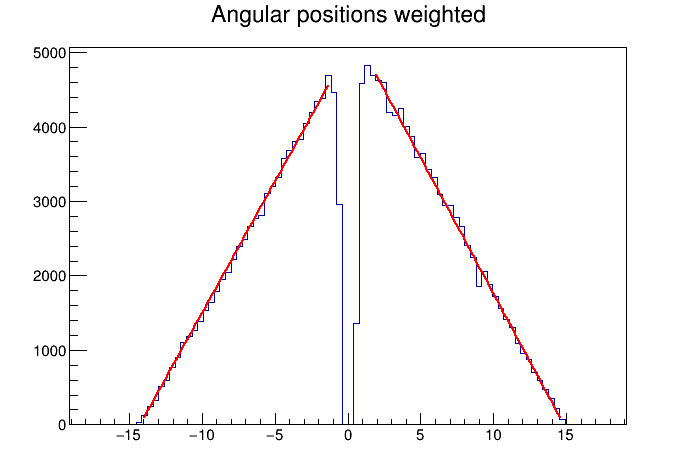

In [26]:
h1_step.SetStats(False)
    
c = ROOT.TCanvas()

lf = ROOT.TF1("lf", "[0] + [1]*x", -0.22 * RAD2STEP, -0.02 * RAD2STEP)
rf = ROOT.TF1("rf", "[0] + [1]*x",  0.03 * RAD2STEP,  0.23 * RAD2STEP)

h1_step.Draw('HIST')
lfit = h1_step.Fit('lf', 'RS')
rfit = h1_step.Fit('rf', 'RS')

lf.Draw("SAME")
rf.Draw("SAME")

# c.SetLogy()
c.Draw()

In [15]:
lpar = [lfit.Get().Parameter(i) for i in range(2)]
rpar = [rfit.Get().Parameter(i) for i in range(2)]

In [16]:
lx0 = - lpar[0] / lpar[1]
rx0 = - rpar[0] / rpar[1]

In [17]:
print("Delta [step]:   ", rx0 - lx0)
print("x0 left [step]: ", lx0)
print("x0 right [step]:", rx0)

Delta [step]:    29.060857921896456
x0 left [step]:  -14.222999312727108
x0 right [step]: 14.837858609169347


### Using `17_DC` file

In [18]:
files = [
    "gold_17_DC_2h.root"
]

etimes = [
    120
]

weigths = [
    1.0
]

Area_thr  = 13
Ratio_thr = 3.21

In [19]:
h2_step = ROOT.TH1F('h2_step', 'Angular positions weighted', bins, -15, 15)

pars  = []
fits  = []
hists = []

for i in range(len(files)):
    file = ROOT.TFile.Open(DATA_PATH + files[i])
    tree = file.Get("tree")
    
    Areas   = tree.AsMatrix(['Rareas'])
    Means   = tree.AsMatrix(['Rmeanx','Rmeany'])
    Theta   = tree.AsMatrix(['Rtheta'])
    Exptime = tree.AsMatrix(['Reetime'])
    Ratios  = tree.AsMatrix(['Rratios'])
    
    mask_thr =  np.logical_and (np.squeeze(Areas)      > Area_thr, np.squeeze(Ratios)     < Ratio_thr)
    mask_x   =  np.logical_and (np.squeeze(Means[:,0]) > xmin    , np.squeeze(Means[:,0]) < xmax     )
    mask_y   =  np.logical_and (np.squeeze(Means[:,1]) > ymin    , np.squeeze(Means[:,1]) < ymax     )
    
    mask = np.logical_and(mask_thr, np.logical_and(mask_x, mask_y))
    
    Areas_disc   = Areas [mask]
    Means_disc   = Means [mask]
    Theta_disc   = Theta [mask]
    Exptime_disc = Exptime[mask]
    Ratios_disc  = Ratios[mask]
    
    for t in Theta_disc:
        h2_step.Fill(t * RAD2STEP, weigths[i])
    
    file.Close()

 FCN=25.4149 FROM MIGRAD    STATUS=CONVERGED      32 CALLS          33 TOTAL
                     EDM=4.19953e-20    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.00834e+03   2.85793e+01   1.87258e-02   1.37549e-11
   2  p1           1.40360e+02   4.32773e+00   2.83563e-03  -2.50577e-11
 FCN=24.8898 FROM MIGRAD    STATUS=CONVERGED      32 CALLS          33 TOTAL
                     EDM=1.12042e-20    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.12407e+03   2.98932e+01   1.95104e-02  -1.04704e-11
   2  p1          -1.40503e+02   4.54987e+00   2.96957e-03  -3.88821e-11


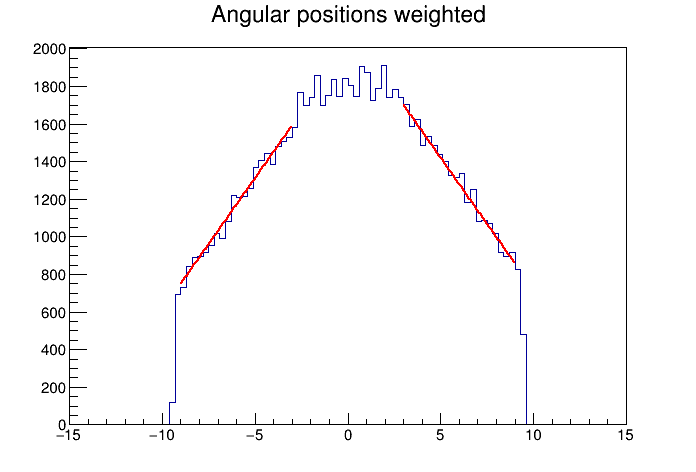

In [20]:
h2_step.SetStats(False)
    
c = ROOT.TCanvas()

lf = ROOT.TF1("lf", "[0] + [1]*x", -9, -3)
rf = ROOT.TF1("rf", "[0] + [1]*x",  3,  9)

h2_step.Draw('HIST')
lfit = h2_step.Fit('lf', 'RS')
rfit = h2_step.Fit('rf', 'RS')

lf.Draw("SAME")
rf.Draw("SAME")

# TC.SetLogy()
c.Draw()

In [21]:
lpar = [lfit.Get().Parameter(i) for i in range(2)]
rpar = [rfit.Get().Parameter(i) for i in range(2)]

In [22]:
lx0 = - lpar[0] / lpar[1]
rx0 = - rpar[0] / rpar[1]

In [23]:
print("Delta [step]:   ", rx0 - lx0)
print("x0 left [step]: ", lx0)
print("x0 right [step]:", rx0)

Delta [step]:    29.426151984328506
x0 left [step]:  -14.308489961751386
x0 right [step]: 15.11766202257712
